# Predicting faulty water pumps

# Pre-processing, Modelling & Evaluation¶

## Import Libraries
Import libraries necessary to get the exploratory data analysis (EDA) part of the project set-up

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import itertools

# Import Preprocessing and ML libraries
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
num_procs = 4

### Define Utility Functions 

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_model(model, features_test, labels_test):
    predictions = model.predict(features_test)
    errors = abs(predictions - test_labels)
    percent_error = 100 * np.mean(errors / labels_test)
    accuracy = 100 - percent_error
    print('Model Performance')
    print('Average Error: {:0.2f}'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%.'.format(accuracy))    
    return accuracy

## Load Water Pump Clean Data Frames

Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [34]:
!dir clean-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

06/13/2018  01:14 PM        25,569,696 clean_pump_train_features_df.pkl
               1 File(s)     25,569,696 bytes
               0 Dir(s)  1,928,122,810,368 bytes free


In [35]:
clean_train_features_df = pd.read_pickle('clean-data\clean_pump_train_features_df.pkl')

print("Confirm shapes of the clean train dataframes",clean_train_features_df.shape)

('Confirm shapes of the clean train dataframes', (59400, 34))


In [36]:
display(clean_train_features_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 34 columns):
amount_tsh               59400 non-null float64
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null object
district_code            59400 non-null object
lga                      59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null bool
scheme_management        59400 non-null object
permit                   59400 non-null bool
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
ma

None

## Pre-process the data
### Encode the categorical features

In [37]:
# Encode target feature (0 -> functional, 1 -> non functional, 2 -> functional needs repair)
label_list = clean_train_features_df['status_group'].unique()
print(label_list)

['functional' 'non functional' 'functional needs repair']


In [38]:
clean_train_features_df['status_group'] = pd.Categorical(clean_train_features_df['status_group']).codes
clean_train_features_df['status_group'].head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int8

In [39]:
# One hot encode boolean features 
bool_cols = ['public_meeting', 'permit']
for col in bool_cols:
    clean_train_features_df[col] = clean_train_features_df[col] * 1
    
clean_train_features_df[bool_cols].head()

,public_meeting,permit
0,1,0
1,1,1
2,1,1
3,1,1
4,1,1


In [40]:
categorical_cols = ['funder', 'installer', 'basin', 'region', 'region_code', 'district_code', 'lga', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [41]:
# One hot encode all other categorical features 
cat_df = pd.get_dummies(clean_train_features_df[categorical_cols])
cat_df.shape

(59400, 4173)

Due the very large cardinality of the categorical variables, we can see that we end up with huge number of dimensions. <br/>
We will use PCA to manage this issue when modelling.

### Create a new pre-processed data set

In [42]:
# Select the numerical features 
numerical_cols = clean_train_features_df.select_dtypes(include=['int64']).columns.tolist()
numerical_cols += clean_train_features_df.select_dtypes(include=['float64']).columns.tolist()
num_df = clean_train_features_df[numerical_cols].apply(pd.to_numeric)
num_df.head()

,gps_height,population,construction_year,pump_age,amount_tsh,longitude,latitude
0,1390,109,1999,12,6000.0,34.938093,-9.856322
1,1399,280,2010,3,0.0,34.698766,-2.147466
2,686,250,2009,4,25.0,37.460664,-3.821329
3,263,58,1986,27,0.0,38.486161,-11.155298
4,0,0,2000,11,0.0,31.130847,-1.825359


In [43]:
# Concatenate both numerical and one hot encoded categorical features
train_features_df = pd.concat([cat_df, clean_train_features_df[bool_cols], num_df, clean_train_features_df['status_group']], axis=1)

In [44]:
train_features_df.shape

(59400, 4183)

### Create and Evaluate a Logistic Regression Pipeline

#### Split Training data

In [15]:
target_y = train_features_df['status_group']
feature_X = train_features_df.drop('status_group',axis=1)

In [16]:
# Split the data in a train and validation set (30% , 70%)
X_train, X_test, y_train, y_test = train_test_split(feature_X, target_y, test_size=0.30, random_state=101)

#### Train Logistic Regression

In [17]:
# Use a pipeline with PCA and logistic regression as our baseline
# Logistic regression: ovr = one (class) versus rest (of classes)
lr_std_pca_model = make_pipeline(StandardScaler(), PCA(), LogisticRegression(multi_class='ovr', n_jobs=num_procs)) 

# Fit the model
lr_std_pca_model.fit(X_train,y_train)

# model accuracy score between 0% and 100%
status_predictions = lr_std_pca_model.predict(X_test)
#score = LR.score(dfLR_tst[predictors].values, dfLR_tst['status_group_enc'].values)

C:\Users\Chris Cochet\Anaconda3\envs\Udacity_MLND\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


#### Evaluate Water Pump Status Classification Results

In [18]:
# print the classification report 
print(classification_report(y_test,status_predictions))

             precision    recall  f1-score   support

          0       0.75      0.89      0.81      9550
          1       0.54      0.17      0.25      1330
          2       0.80      0.70      0.75      6940

avg / total       0.75      0.76      0.74     17820



Confusion matrix, without normalization
[[8472  121  957]
 [ 848  222  260]
 [2024   71 4845]]


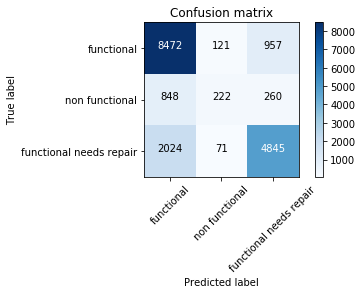

In [19]:
cm = confusion_matrix(y_test,status_predictions)
plot_confusion_matrix(cm, label_list)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [10,50,100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [191]:
base_rf_model = RandomForestRegressor(n_estimators = 10, n_jobs=num_procs, random_state = 101)

base_rf_model.fit(X_train, y_train)
base_accuracy = evaluate(base_rf_model, X_train, test_y_trainlabels)

NameError: name 'RandomForestRegressor' is not defined

In [190]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

NameError: name 'rf_random' is not defined

In [ ]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)

gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

In [49]:
clean_train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 34 columns):
amount_tsh               59400 non-null float64
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null object
district_code            59400 non-null object
lga                      59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null int32
scheme_management        59400 non-null object
permit                   59400 non-null int32
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object


In [54]:
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=num_procs)
rf_model.fit(X_train,y_train)

ValueError: could not convert string to float: communal standpipe

             precision    recall  f1-score   support

          0       0.80      0.87      0.84      9550
          1       0.50      0.35      0.41      1330
          2       0.83      0.78      0.80      6940

avg / total       0.79      0.80      0.79     17820

0.79657687991
Confusion matrix, without normalization
[[8306  315  929]
 [ 644  466  220]
 [1372  145 5423]]


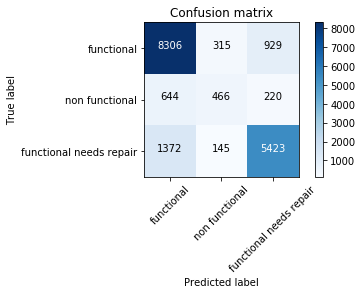

In [51]:
status_predictions = rf_model.predict(X_test)
# print the classification report 
print(classification_report(y_test,status_predictions))
print (accuracy_score(y_test, status_predictions, normalize=True))
cm = confusion_matrix(y_test,status_predictions)
plot_confusion_matrix(cm, label_list)
plt.show()

In [52]:
gbm_model = GradientBoostingClassifier(n_estimators=150)
gbm_model.fit(X_train,y_train)
status_predictions = gbm_model.predict(X_test)

KeyboardInterrupt: 

In [ ]:
# print the classification report 
print(classification_report(y_test,status_predictions))
print (accuracy_score(y_test, status_predictions, normalize=True))
cm = confusion_matrix(y_test,status_predictions)
plot_confusion_matrix(cm, label_list)
plt.show()

In [ ]:
 ### XGBoost and LightGBM
    mport lightgbm as lgb